In [1]:
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CFG = {
#     'TRAIN_WINDOW_SIZE':365, # 365일치로 학습
#     'PREDICT_SIZE':28, # 28일치 예측
#     'EPOCHS':50,
#     'LEARNING_RATE':1e-4,
#     'BATCH_SIZE':16,
#     'SEED':41
# }

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':427, # 365+59+3일치로 학습
    'PREDICT_SIZE':28, # 28일치 예측
    'EPOCHS':20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed_all(seed) # multi-gpu seed 고정

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [6]:
def normalization(train_list):
    scale_max_list = []
    scale_min_list = []
    
    column_list=['price', 'year', 'month', 'day', 'weekdays']
    for data in tqdm(train_list):
        for col in tqdm(column_list):
            maxi=np.max(data.loc[:, col])
            mini=np.min(data.loc[:, col])
            
            if maxi == mini :
                tdata.loc[:, col] = 0
            else:
                data.loc[:, col] = (data.loc[:, col] - mini) / (maxi - mini)
            
            if col == 'price':
                scale_max_list.append(maxi)
                scale_min_list.append(mini)
    return train_list, scale_max_list, scale_min_list

In [7]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    data = data.drop(columns=['timestamp', 'item', 'corporation', 'location', 'supply','year','month','day','holiday'])
    data = data.reset_index(drop=True)
    window_size = train_size + predict_size

    price_data = data.loc[:,'price']
    input_data, target_data = [], []
    
    for j in range(0, len(data) - window_size):
        input_data.append(data.loc[j:j+train_size-1].values)
        target_data.append(data.loc[j+train_size:j+window_size-1, 'price'].values)
    return np.array(input_data), np.squeeze(target_data)

In [8]:
def make_test_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    data = data.drop(columns=['timestamp', 'item', 'corporation', 'location', 'supply','year','month','day','holiday'])
    price_data = data.loc[:,'price']
    input_data=data.tail(train_size).values.reshape(1, train_size, 3)
    return np.array(input_data)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [10]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        x = x.permute(0,2,1) # [batch_size, forcast_size, channels]
        x = x[:, :, 0].squeeze(1) # 마지막 column(price만 고려        
        return x

In [11]:
def train(model, optimizer, train_loader, val_loader, device):
    model = nn.DataParallel(model, device_ids=[0, 1], output_device=0)
    model.to(device)

    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in tqdm(iter(train_loader)):
            X, Y = X.to(device), Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_RMSE = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.sqrt(np.mean(train_loss)):.5f}] Val Loss : [{val_RMSE:.5f}]')

        if best_loss > val_RMSE:
            best_loss = val_RMSE 
            best_model = model
            print('Model Saved')
    return best_model

def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.sqrt(np.mean(val_loss))

In [12]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

## training & inference

In [13]:
import glob
file_pattern = '../DAT/train_TG_*.csv'  # 파일 이름 패턴을 지정 (*은 번호에 해당)
file_list = glob.glob(file_pattern)

train_TG_list = []

for file in file_list:
    df = pd.read_csv(file)
    train_TG_list.append(df)

In [14]:
import glob
file_pattern = '../DAT/train_CR_*.csv'  # 파일 이름 패턴을 지정 (*은 번호에 해당)
file_list = glob.glob(file_pattern)

train_CR_list = []

for file in file_list:
    df = pd.read_csv(file)
    train_CR_list.append(df)

In [15]:
import glob
file_pattern = '../DAT/train_CB_*.csv'  # 파일 이름 패턴을 지정 (*은 번호에 해당)
file_list = glob.glob(file_pattern)

train_CB_list = []

for file in file_list:
    df = pd.read_csv(file)
    train_CB_list.append(df)

In [16]:
import glob
file_pattern = '../DAT/train_RD_*.csv'  # 파일 이름 패턴을 지정 (*은 번호에 해당)
file_list = glob.glob(file_pattern)

train_RD_list = []

for file in file_list:
    df = pd.read_csv(file)
    train_RD_list.append(df)

In [17]:
import glob
file_pattern = '../DAT/train_BC_*.csv'  # 파일 이름 패턴을 지정 (*은 번호에 해당)
file_list = glob.glob(file_pattern)

train_BC_list = []

for file in file_list:
    df = pd.read_csv(file)
    train_BC_list.append(df)

In [18]:
# train_list=[train_TG_list, train_CR_list, train_CB_list, train_RD_list, train_BC_list]
# result=[]

# for item_list in train_list:
#     item_list, max_list, min_list=normalization(item_list)
#     result.append([max_list, min_list])

In [19]:
# result

In [20]:
preds_TG=[]
for i in range(len(train_TG_list)):
    train_input, train_target= make_train_data(train_TG_list[i])
    test_input=make_test_data(train_TG_list[i])
    
    data_len = len(train_input)
    val_input = train_input[-int(data_len*0.2):]
    val_target = train_target[-int(data_len*0.2):]
    train_input = train_input[:-int(data_len*0.2)]
    train_target = train_target[:-int(data_len*0.2)]
    
    train_dataset = CustomDataset(train_input, train_target)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_input, val_target)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_input, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model =  LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], 
                      forcast_size=CFG["PREDICT_SIZE"], 
                      kernel_size=25,
                      individual=False, 
                      feature_size=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    infer_model = train(model, optimizer, train_loader, val_loader, device)
    print('train_TG_list[',i,'] train & inference 완료')
    print('-------------------------------------------------------------------------')
    print('')
    pred = inference(infer_model, test_loader, device)
    preds_TG.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 519.77it/s]


Epoch : [1] Train Loss : [2333.18139] Val Loss : [1583.85248]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.79it/s]


Epoch : [2] Train Loss : [1715.95651] Val Loss : [1584.85823]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.05it/s]


Epoch : [3] Train Loss : [1547.49391] Val Loss : [1517.47970]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.57it/s]


Epoch : [4] Train Loss : [1461.26774] Val Loss : [1473.29060]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.61it/s]


Epoch : [5] Train Loss : [1403.05885] Val Loss : [1444.32969]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.01it/s]


Epoch : [6] Train Loss : [1359.71041] Val Loss : [1424.97725]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.87it/s]


Epoch : [7] Train Loss : [1337.49275] Val Loss : [1405.02232]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.41it/s]


Epoch : [8] Train Loss : [1313.95741] Val Loss : [1435.09786]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.61it/s]


Epoch : [9] Train Loss : [1303.85935] Val Loss : [1372.50213]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 558.61it/s]


Epoch : [10] Train Loss : [1279.22893] Val Loss : [1383.14460]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.07it/s]


Epoch : [11] Train Loss : [1266.39451] Val Loss : [1392.30859]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.27it/s]


Epoch : [12] Train Loss : [1258.78351] Val Loss : [1393.24095]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.90it/s]


Epoch : [13] Train Loss : [1248.62071] Val Loss : [1413.70078]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.79it/s]


Epoch : [14] Train Loss : [1235.02639] Val Loss : [1401.80939]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.50it/s]


Epoch : [15] Train Loss : [1227.40131] Val Loss : [1411.03162]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.40it/s]


Epoch : [16] Train Loss : [1219.90086] Val Loss : [1403.60387]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [17] Train Loss : [1215.23294] Val Loss : [1405.28278]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [18] Train Loss : [1208.09642] Val Loss : [1414.54379]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.44it/s]


Epoch : [19] Train Loss : [1197.38171] Val Loss : [1424.21818]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.43it/s]


Epoch : [20] Train Loss : [1195.74830] Val Loss : [1445.96304]
train_TG_list[ 0 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.99it/s]


Epoch : [1] Train Loss : [1813.88605] Val Loss : [940.13572]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [2] Train Loss : [1325.64963] Val Loss : [949.76612]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.12it/s]


Epoch : [3] Train Loss : [1235.91788] Val Loss : [958.34403]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [4] Train Loss : [1201.27224] Val Loss : [927.53804]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.35it/s]


Epoch : [5] Train Loss : [1171.07579] Val Loss : [900.21656]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 626.28it/s]


Epoch : [6] Train Loss : [1146.28388] Val Loss : [868.31513]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [7] Train Loss : [1130.91980] Val Loss : [870.72517]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.72it/s]


Epoch : [8] Train Loss : [1121.77884] Val Loss : [855.97219]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 532.49it/s]


Epoch : [9] Train Loss : [1107.20787] Val Loss : [843.38007]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.40it/s]


Epoch : [10] Train Loss : [1099.76125] Val Loss : [838.62893]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.39it/s]


Epoch : [11] Train Loss : [1087.95261] Val Loss : [835.48639]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.21it/s]


Epoch : [12] Train Loss : [1088.86732] Val Loss : [859.69331]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.92it/s]


Epoch : [13] Train Loss : [1083.15496] Val Loss : [878.78602]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.41it/s]


Epoch : [14] Train Loss : [1074.69368] Val Loss : [837.37048]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 534.26it/s]


Epoch : [15] Train Loss : [1072.28754] Val Loss : [830.32897]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.04it/s]


Epoch : [16] Train Loss : [1062.00798] Val Loss : [870.43859]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.31it/s]


Epoch : [17] Train Loss : [1063.22949] Val Loss : [841.66421]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.27it/s]


Epoch : [18] Train Loss : [1058.31332] Val Loss : [839.59881]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.56it/s]


Epoch : [19] Train Loss : [1056.55965] Val Loss : [840.54044]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.42it/s]


Epoch : [20] Train Loss : [1047.47707] Val Loss : [835.11419]
train_TG_list[ 1 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 517.92it/s]


Epoch : [1] Train Loss : [1885.02520] Val Loss : [1000.45443]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 521.17it/s]


Epoch : [2] Train Loss : [1269.68904] Val Loss : [1026.16170]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [3] Train Loss : [1156.41404] Val Loss : [1000.05351]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.53it/s]


Epoch : [4] Train Loss : [1114.25294] Val Loss : [952.17727]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [5] Train Loss : [1072.21549] Val Loss : [931.64681]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.22it/s]


Epoch : [6] Train Loss : [1041.40220] Val Loss : [915.74834]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.54it/s]


Epoch : [7] Train Loss : [1022.29715] Val Loss : [906.40232]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.52it/s]


Epoch : [8] Train Loss : [1009.89960] Val Loss : [872.87164]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.42it/s]


Epoch : [9] Train Loss : [999.56956] Val Loss : [853.22800]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.52it/s]


Epoch : [10] Train Loss : [979.92537] Val Loss : [841.61188]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [11] Train Loss : [975.89639] Val Loss : [842.18118]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.51it/s]


Epoch : [12] Train Loss : [971.05176] Val Loss : [842.77264]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.34it/s]


Epoch : [13] Train Loss : [957.64938] Val Loss : [833.05800]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.68it/s]


Epoch : [14] Train Loss : [952.80208] Val Loss : [844.23263]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.06it/s]


Epoch : [15] Train Loss : [947.58132] Val Loss : [864.65883]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.60it/s]


Epoch : [16] Train Loss : [944.84787] Val Loss : [852.63816]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.51it/s]


Epoch : [17] Train Loss : [944.70656] Val Loss : [845.80973]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.41it/s]


Epoch : [18] Train Loss : [937.09665] Val Loss : [902.17486]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 567.46it/s]


Epoch : [19] Train Loss : [935.36474] Val Loss : [874.79747]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.16it/s]


Epoch : [20] Train Loss : [931.52567] Val Loss : [852.76095]
train_TG_list[ 2 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.86it/s]


Epoch : [1] Train Loss : [2314.90659] Val Loss : [1420.02178]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.32it/s]


Epoch : [2] Train Loss : [1690.98976] Val Loss : [1523.75362]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.35it/s]


Epoch : [3] Train Loss : [1532.75253] Val Loss : [1470.69976]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.89it/s]


Epoch : [4] Train Loss : [1457.92337] Val Loss : [1356.80392]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.34it/s]


Epoch : [5] Train Loss : [1408.09849] Val Loss : [1432.54273]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.17it/s]


Epoch : [6] Train Loss : [1361.31105] Val Loss : [1299.67515]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.05it/s]


Epoch : [7] Train Loss : [1329.59090] Val Loss : [1296.01571]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 486.88it/s]


Epoch : [8] Train Loss : [1311.30749] Val Loss : [1335.99296]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.88it/s]


Epoch : [9] Train Loss : [1297.81549] Val Loss : [1313.04860]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.33it/s]


Epoch : [10] Train Loss : [1288.53567] Val Loss : [1345.82630]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 368.38it/s]


Epoch : [11] Train Loss : [1282.44680] Val Loss : [1317.62388]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.69it/s]


Epoch : [12] Train Loss : [1271.77084] Val Loss : [1371.60230]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 537.81it/s]


Epoch : [13] Train Loss : [1261.56499] Val Loss : [1329.54918]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.44it/s]


Epoch : [14] Train Loss : [1261.58630] Val Loss : [1377.02382]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [15] Train Loss : [1248.08840] Val Loss : [1364.99824]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [16] Train Loss : [1245.62741] Val Loss : [1363.14937]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.41it/s]


Epoch : [17] Train Loss : [1237.56895] Val Loss : [1376.67464]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.02it/s]


Epoch : [18] Train Loss : [1235.92566] Val Loss : [1332.30739]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.05it/s]


Epoch : [19] Train Loss : [1226.55887] Val Loss : [1395.00927]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 581.94it/s]


Epoch : [20] Train Loss : [1232.33087] Val Loss : [1391.35608]
train_TG_list[ 3 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.27it/s]


Epoch : [1] Train Loss : [1773.25973] Val Loss : [950.62921]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.08it/s]


Epoch : [2] Train Loss : [1185.60131] Val Loss : [945.29459]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.09it/s]


Epoch : [3] Train Loss : [1076.58708] Val Loss : [920.30053]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.28it/s]


Epoch : [4] Train Loss : [1023.68010] Val Loss : [888.91449]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.16it/s]


Epoch : [5] Train Loss : [984.35503] Val Loss : [852.59305]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.59it/s]


Epoch : [6] Train Loss : [951.78233] Val Loss : [831.99273]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.67it/s]


Epoch : [7] Train Loss : [933.05179] Val Loss : [800.53359]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 506.66it/s]


Epoch : [8] Train Loss : [911.88562] Val Loss : [808.26779]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.95it/s]


Epoch : [9] Train Loss : [898.90194] Val Loss : [789.52338]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.18it/s]


Epoch : [10] Train Loss : [889.95542] Val Loss : [780.75064]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.00it/s]


Epoch : [11] Train Loss : [879.43371] Val Loss : [816.72383]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.42it/s]


Epoch : [12] Train Loss : [880.60555] Val Loss : [768.53351]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.47it/s]


Epoch : [13] Train Loss : [871.35931] Val Loss : [780.17310]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [14] Train Loss : [863.78448] Val Loss : [767.85884]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.98it/s]


Epoch : [15] Train Loss : [865.73270] Val Loss : [754.29681]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.51it/s]


Epoch : [16] Train Loss : [857.49968] Val Loss : [781.39464]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.57it/s]


Epoch : [17] Train Loss : [863.78922] Val Loss : [760.77287]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 606.83it/s]


Epoch : [18] Train Loss : [856.37179] Val Loss : [770.82785]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.01it/s]


Epoch : [19] Train Loss : [842.47941] Val Loss : [763.16676]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.90it/s]


Epoch : [20] Train Loss : [842.70330] Val Loss : [753.30552]
Model Saved
train_TG_list[ 4 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [1] Train Loss : [2732.23204] Val Loss : [1481.18929]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.69it/s]


Epoch : [2] Train Loss : [2021.36693] Val Loss : [1476.31381]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.26it/s]


Epoch : [3] Train Loss : [1861.39979] Val Loss : [1449.69824]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.99it/s]


Epoch : [4] Train Loss : [1774.15533] Val Loss : [1413.32625]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 537.91it/s]


Epoch : [5] Train Loss : [1700.89049] Val Loss : [1557.87736]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.54it/s]


Epoch : [6] Train Loss : [1661.45942] Val Loss : [1376.85511]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [7] Train Loss : [1613.35546] Val Loss : [1428.36149]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.02it/s]


Epoch : [8] Train Loss : [1588.11589] Val Loss : [1388.00420]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.27it/s]


Epoch : [9] Train Loss : [1574.18947] Val Loss : [1481.61582]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [10] Train Loss : [1548.41474] Val Loss : [1416.99829]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.22it/s]


Epoch : [11] Train Loss : [1539.79859] Val Loss : [1404.06865]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.98it/s]


Epoch : [12] Train Loss : [1521.36866] Val Loss : [1347.85152]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [13] Train Loss : [1511.22232] Val Loss : [1424.83385]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.31it/s]


Epoch : [14] Train Loss : [1504.23229] Val Loss : [1540.62455]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.12it/s]


Epoch : [15] Train Loss : [1492.28838] Val Loss : [1515.77077]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.03it/s]


Epoch : [16] Train Loss : [1488.03738] Val Loss : [1472.12502]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 437.32it/s]


Epoch : [17] Train Loss : [1473.27104] Val Loss : [1385.47024]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.93it/s]


Epoch : [18] Train Loss : [1469.36134] Val Loss : [1458.32195]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [19] Train Loss : [1459.59186] Val Loss : [1509.36840]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [20] Train Loss : [1459.14433] Val Loss : [1494.89187]
train_TG_list[ 5 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.52it/s]


Epoch : [1] Train Loss : [1993.69822] Val Loss : [1016.38250]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [2] Train Loss : [1392.21229] Val Loss : [1018.26948]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 579.31it/s]


Epoch : [3] Train Loss : [1251.50659] Val Loss : [998.66973]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.78it/s]


Epoch : [4] Train Loss : [1191.35998] Val Loss : [950.61355]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.82it/s]


Epoch : [5] Train Loss : [1142.88550] Val Loss : [906.99890]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.25it/s]


Epoch : [6] Train Loss : [1104.82561] Val Loss : [869.78929]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.01it/s]


Epoch : [7] Train Loss : [1075.68537] Val Loss : [844.35284]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [8] Train Loss : [1052.47134] Val Loss : [813.53051]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.48it/s]


Epoch : [9] Train Loss : [1033.01553] Val Loss : [804.02833]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.39it/s]


Epoch : [10] Train Loss : [1020.08495] Val Loss : [801.96029]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 439.81it/s]


Epoch : [11] Train Loss : [1010.68232] Val Loss : [782.21584]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.18it/s]


Epoch : [12] Train Loss : [1005.79473] Val Loss : [839.51500]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.41it/s]


Epoch : [13] Train Loss : [998.07633] Val Loss : [814.36422]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.94it/s]


Epoch : [14] Train Loss : [992.67255] Val Loss : [794.23429]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 502.48it/s]


Epoch : [15] Train Loss : [986.81791] Val Loss : [783.84564]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.02it/s]


Epoch : [16] Train Loss : [976.63000] Val Loss : [786.86459]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.00it/s]


Epoch : [17] Train Loss : [970.95629] Val Loss : [821.96902]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.32it/s]


Epoch : [18] Train Loss : [970.97255] Val Loss : [798.71456]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.55it/s]


Epoch : [19] Train Loss : [964.24902] Val Loss : [782.67913]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 534.13it/s]


Epoch : [20] Train Loss : [959.13365] Val Loss : [786.69997]
train_TG_list[ 6 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.28it/s]


Epoch : [1] Train Loss : [2167.67675] Val Loss : [1390.29469]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [2] Train Loss : [1680.73131] Val Loss : [1434.96997]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.24it/s]


Epoch : [3] Train Loss : [1563.05897] Val Loss : [1448.33542]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.00it/s]


Epoch : [4] Train Loss : [1497.69169] Val Loss : [1417.56407]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.18it/s]


Epoch : [5] Train Loss : [1453.06218] Val Loss : [1421.95458]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 562.05it/s]


Epoch : [6] Train Loss : [1413.80721] Val Loss : [1448.90446]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.63it/s]


Epoch : [7] Train Loss : [1389.48960] Val Loss : [1407.84814]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.80it/s]


Epoch : [8] Train Loss : [1367.83289] Val Loss : [1463.26485]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.48it/s]


Epoch : [9] Train Loss : [1350.74346] Val Loss : [1441.00047]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.10it/s]


Epoch : [10] Train Loss : [1338.71311] Val Loss : [1444.28181]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.52it/s]


Epoch : [11] Train Loss : [1324.63692] Val Loss : [1458.80433]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 484.77it/s]


Epoch : [12] Train Loss : [1317.05160] Val Loss : [1441.55043]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.22it/s]


Epoch : [13] Train Loss : [1308.26722] Val Loss : [1519.64633]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 482.27it/s]


Epoch : [14] Train Loss : [1301.66618] Val Loss : [1465.22230]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.09it/s]


Epoch : [15] Train Loss : [1294.96742] Val Loss : [1491.05790]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [16] Train Loss : [1284.38138] Val Loss : [1505.34207]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.50it/s]


Epoch : [17] Train Loss : [1279.49513] Val Loss : [1522.59651]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.60it/s]


Epoch : [18] Train Loss : [1278.52885] Val Loss : [1491.94242]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.84it/s]


Epoch : [19] Train Loss : [1267.32153] Val Loss : [1508.04433]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 558.87it/s]


Epoch : [20] Train Loss : [1269.06943] Val Loss : [1543.63767]
train_TG_list[ 7 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.36it/s]


Epoch : [1] Train Loss : [2066.58579] Val Loss : [1155.87507]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.54it/s]


Epoch : [2] Train Loss : [1564.65302] Val Loss : [1160.32378]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.06it/s]


Epoch : [3] Train Loss : [1448.96696] Val Loss : [1144.81180]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [4] Train Loss : [1398.53096] Val Loss : [1065.18614]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.60it/s]


Epoch : [5] Train Loss : [1355.26053] Val Loss : [1033.35177]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 280.01it/s]


Epoch : [6] Train Loss : [1330.76821] Val Loss : [1040.61119]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.78it/s]


Epoch : [7] Train Loss : [1307.38876] Val Loss : [1052.34941]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [8] Train Loss : [1288.85206] Val Loss : [995.96222]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 343.07it/s]


Epoch : [9] Train Loss : [1271.16647] Val Loss : [1001.81257]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.07it/s]


Epoch : [10] Train Loss : [1257.74820] Val Loss : [964.71625]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.33it/s]


Epoch : [11] Train Loss : [1252.68847] Val Loss : [980.25659]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 565.43it/s]


Epoch : [12] Train Loss : [1242.14681] Val Loss : [967.37835]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [13] Train Loss : [1236.70883] Val Loss : [1042.04843]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.33it/s]


Epoch : [14] Train Loss : [1230.32922] Val Loss : [953.44362]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.29it/s]


Epoch : [15] Train Loss : [1223.74055] Val Loss : [994.17184]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.17it/s]


Epoch : [16] Train Loss : [1219.32111] Val Loss : [969.63000]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 627.97it/s]


Epoch : [17] Train Loss : [1221.45958] Val Loss : [958.84778]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.39it/s]


Epoch : [18] Train Loss : [1209.21455] Val Loss : [979.94884]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.41it/s]


Epoch : [19] Train Loss : [1199.65207] Val Loss : [976.51129]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.23it/s]


Epoch : [20] Train Loss : [1199.33314] Val Loss : [971.63274]
train_TG_list[ 8 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.60it/s]


Epoch : [1] Train Loss : [2166.42902] Val Loss : [1262.30240]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.30it/s]


Epoch : [2] Train Loss : [1749.11590] Val Loss : [1283.04910]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.95it/s]


Epoch : [3] Train Loss : [1638.46759] Val Loss : [1269.79394]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.84it/s]


Epoch : [4] Train Loss : [1578.42050] Val Loss : [1266.69904]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.72it/s]


Epoch : [5] Train Loss : [1547.15706] Val Loss : [1199.35906]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.44it/s]


Epoch : [6] Train Loss : [1514.08559] Val Loss : [1202.09200]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.64it/s]


Epoch : [7] Train Loss : [1493.34782] Val Loss : [1190.57129]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 567.75it/s]


Epoch : [8] Train Loss : [1475.86835] Val Loss : [1171.74162]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.34it/s]


Epoch : [9] Train Loss : [1467.22942] Val Loss : [1178.72720]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.00it/s]


Epoch : [10] Train Loss : [1445.43256] Val Loss : [1154.36386]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.63it/s]


Epoch : [11] Train Loss : [1428.98913] Val Loss : [1166.29904]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [12] Train Loss : [1426.97124] Val Loss : [1178.34831]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.10it/s]


Epoch : [13] Train Loss : [1421.15919] Val Loss : [1216.63270]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [14] Train Loss : [1408.13582] Val Loss : [1167.24957]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.57it/s]


Epoch : [15] Train Loss : [1396.75864] Val Loss : [1174.04925]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 525.65it/s]


Epoch : [16] Train Loss : [1392.11173] Val Loss : [1211.01872]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.96it/s]


Epoch : [17] Train Loss : [1381.43766] Val Loss : [1178.70845]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.25it/s]


Epoch : [18] Train Loss : [1380.57093] Val Loss : [1194.57126]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.13it/s]


Epoch : [19] Train Loss : [1374.07564] Val Loss : [1204.27066]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.01it/s]


Epoch : [20] Train Loss : [1368.36066] Val Loss : [1216.21421]
train_TG_list[ 9 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


In [21]:
preds_CR=[]
for i in range(len(train_CR_list)):
    train_input, train_target= make_train_data(train_CR_list[i])
    test_input=make_test_data(train_CR_list[i])
    
    data_len = len(train_input)
    val_input = train_input[-int(data_len*0.2):]
    val_target = train_target[-int(data_len*0.2):]
    train_input = train_input[:-int(data_len*0.2)]
    train_target = train_target[:-int(data_len*0.2)]
    
    train_dataset = CustomDataset(train_input, train_target)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_input, val_target)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_input, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model =  LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], 
                      forcast_size=CFG["PREDICT_SIZE"], 
                      kernel_size=25,
                      individual=False, 
                      feature_size=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    infer_model = train(model, optimizer, train_loader, val_loader, device)
    print('train_CR_list[',i,'] train & inference 완료')
    print('-------------------------------------------------------------------------')
    print('')
    pred = inference(infer_model, test_loader, device)
    preds_CR.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.10it/s]


Epoch : [1] Train Loss : [386.30308] Val Loss : [855.18040]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 498.18it/s]


Epoch : [2] Train Loss : [333.78593] Val Loss : [765.91441]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 518.38it/s]


Epoch : [3] Train Loss : [315.00359] Val Loss : [737.80832]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.61it/s]


Epoch : [4] Train Loss : [308.12442] Val Loss : [724.46761]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.16it/s]


Epoch : [5] Train Loss : [298.24667] Val Loss : [715.17017]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.87it/s]


Epoch : [6] Train Loss : [292.40317] Val Loss : [719.08311]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.53it/s]


Epoch : [7] Train Loss : [285.66307] Val Loss : [709.62935]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 481.19it/s]


Epoch : [8] Train Loss : [279.35539] Val Loss : [710.79930]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 587.50it/s]


Epoch : [9] Train Loss : [272.90550] Val Loss : [706.12846]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.37it/s]


Epoch : [10] Train Loss : [266.86009] Val Loss : [712.07561]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.49it/s]


Epoch : [11] Train Loss : [265.46663] Val Loss : [707.62576]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.16it/s]


Epoch : [12] Train Loss : [260.61705] Val Loss : [711.67850]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.87it/s]


Epoch : [13] Train Loss : [254.83713] Val Loss : [710.82353]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]


Epoch : [14] Train Loss : [252.35689] Val Loss : [712.26585]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.48it/s]


Epoch : [15] Train Loss : [248.03687] Val Loss : [714.11673]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.65it/s]


Epoch : [16] Train Loss : [243.71523] Val Loss : [715.91503]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.36it/s]


Epoch : [17] Train Loss : [240.87354] Val Loss : [718.75995]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 544.38it/s]


Epoch : [18] Train Loss : [237.56165] Val Loss : [721.32490]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.46it/s]


Epoch : [19] Train Loss : [235.53093] Val Loss : [719.10098]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.57it/s]


Epoch : [20] Train Loss : [231.48500] Val Loss : [724.24136]
train_CR_list[ 0 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.05it/s]


Epoch : [1] Train Loss : [367.39556] Val Loss : [743.36709]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]


Epoch : [2] Train Loss : [333.08316] Val Loss : [737.43865]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.68it/s]


Epoch : [3] Train Loss : [316.62562] Val Loss : [734.82640]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.20it/s]


Epoch : [4] Train Loss : [304.03439] Val Loss : [736.30294]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.77it/s]


Epoch : [5] Train Loss : [295.57459] Val Loss : [739.07765]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.31it/s]


Epoch : [6] Train Loss : [290.93267] Val Loss : [741.76410]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.39it/s]


Epoch : [7] Train Loss : [284.93867] Val Loss : [744.35448]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.01it/s]


Epoch : [8] Train Loss : [280.65043] Val Loss : [746.80123]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.67it/s]


Epoch : [9] Train Loss : [274.48047] Val Loss : [748.70398]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.98it/s]


Epoch : [10] Train Loss : [271.54585] Val Loss : [750.76120]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.49it/s]


Epoch : [11] Train Loss : [270.30717] Val Loss : [752.78157]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.92it/s]


Epoch : [12] Train Loss : [264.18630] Val Loss : [754.88237]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.75it/s]


Epoch : [13] Train Loss : [258.31812] Val Loss : [756.03778]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [14] Train Loss : [255.18882] Val Loss : [757.65959]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.36it/s]


Epoch : [15] Train Loss : [253.92896] Val Loss : [759.35386]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 594.84it/s]


Epoch : [16] Train Loss : [248.42579] Val Loss : [761.01106]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch : [17] Train Loss : [248.85606] Val Loss : [761.72836]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.55it/s]


Epoch : [18] Train Loss : [244.54143] Val Loss : [763.48551]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.64it/s]


Epoch : [19] Train Loss : [241.17509] Val Loss : [764.71514]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.63it/s]


Epoch : [20] Train Loss : [238.80379] Val Loss : [765.70701]
train_CR_list[ 1 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 579.42it/s]


Epoch : [1] Train Loss : [433.22839] Val Loss : [798.87945]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 494.81it/s]


Epoch : [2] Train Loss : [395.60761] Val Loss : [787.64678]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 587.73it/s]


Epoch : [3] Train Loss : [378.96196] Val Loss : [780.32524]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 595.58it/s]


Epoch : [4] Train Loss : [369.91994] Val Loss : [775.75691]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.08it/s]


Epoch : [5] Train Loss : [357.15125] Val Loss : [772.68468]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.74it/s]


Epoch : [6] Train Loss : [353.65118] Val Loss : [773.53260]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [7] Train Loss : [345.53140] Val Loss : [769.63090]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.63it/s]


Epoch : [8] Train Loss : [338.35129] Val Loss : [772.07794]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.02it/s]


Epoch : [9] Train Loss : [334.15377] Val Loss : [770.65868]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 541.40it/s]


Epoch : [10] Train Loss : [326.27038] Val Loss : [771.68205]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.24it/s]


Epoch : [11] Train Loss : [324.33875] Val Loss : [770.70431]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.81it/s]


Epoch : [12] Train Loss : [318.37299] Val Loss : [770.87198]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.49it/s]


Epoch : [13] Train Loss : [313.25185] Val Loss : [771.94648]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]


Epoch : [14] Train Loss : [312.09634] Val Loss : [772.14078]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.07it/s]


Epoch : [15] Train Loss : [311.56842] Val Loss : [772.51331]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.98it/s]


Epoch : [16] Train Loss : [302.84360] Val Loss : [772.84473]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.35it/s]


Epoch : [17] Train Loss : [301.27906] Val Loss : [773.56742]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 547.13it/s]


Epoch : [18] Train Loss : [298.29857] Val Loss : [773.26508]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.18it/s]


Epoch : [19] Train Loss : [294.75755] Val Loss : [776.16689]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [20] Train Loss : [292.40395] Val Loss : [773.87329]
train_CR_list[ 2 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.80it/s]


Epoch : [1] Train Loss : [482.43046] Val Loss : [828.27846]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.05it/s]


Epoch : [2] Train Loss : [410.33799] Val Loss : [805.30239]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.55it/s]


Epoch : [3] Train Loss : [380.99799] Val Loss : [817.92505]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.78it/s]


Epoch : [4] Train Loss : [363.13524] Val Loss : [804.36499]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.66it/s]


Epoch : [5] Train Loss : [350.18438] Val Loss : [799.77336]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.87it/s]


Epoch : [6] Train Loss : [339.45720] Val Loss : [800.02804]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.10it/s]


Epoch : [7] Train Loss : [336.73047] Val Loss : [803.85629]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Epoch : [8] Train Loss : [330.62085] Val Loss : [808.42590]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.00it/s]


Epoch : [9] Train Loss : [322.66842] Val Loss : [810.85205]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 535.68it/s]


Epoch : [10] Train Loss : [320.28354] Val Loss : [802.89743]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 528.97it/s]


Epoch : [11] Train Loss : [317.31120] Val Loss : [815.03595]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 833.39it/s]


Epoch : [12] Train Loss : [312.10663] Val Loss : [806.84635]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.01it/s]


Epoch : [13] Train Loss : [313.69950] Val Loss : [814.45875]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [14] Train Loss : [308.22810] Val Loss : [803.01179]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.96it/s]


Epoch : [15] Train Loss : [308.17961] Val Loss : [825.49620]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Epoch : [16] Train Loss : [305.86569] Val Loss : [811.23626]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 449.98it/s]


Epoch : [17] Train Loss : [302.45758] Val Loss : [825.10220]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.45it/s]


Epoch : [18] Train Loss : [304.33315] Val Loss : [813.22072]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.73it/s]


Epoch : [19] Train Loss : [299.40290] Val Loss : [821.19802]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.71it/s]


Epoch : [20] Train Loss : [298.82647] Val Loss : [804.58964]
train_CR_list[ 3 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.90it/s]


Epoch : [1] Train Loss : [16.80202] Val Loss : [0.03679]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.60it/s]


Epoch : [2] Train Loss : [16.71709] Val Loss : [0.03720]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.70it/s]


Epoch : [3] Train Loss : [16.32881] Val Loss : [0.03716]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Epoch : [4] Train Loss : [16.17554] Val Loss : [0.03768]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.92it/s]


Epoch : [5] Train Loss : [15.53098] Val Loss : [0.03808]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.65it/s]


Epoch : [6] Train Loss : [15.43933] Val Loss : [0.03833]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.56it/s]


Epoch : [7] Train Loss : [15.18788] Val Loss : [0.03872]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.53it/s]


Epoch : [8] Train Loss : [14.92543] Val Loss : [0.03934]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 482.08it/s]


Epoch : [9] Train Loss : [14.51384] Val Loss : [0.03961]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 437.05it/s]


Epoch : [10] Train Loss : [14.46203] Val Loss : [0.04005]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.88it/s]


Epoch : [11] Train Loss : [14.21836] Val Loss : [0.04074]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.98it/s]


Epoch : [12] Train Loss : [14.30416] Val Loss : [0.04114]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch : [13] Train Loss : [13.58737] Val Loss : [0.04174]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]


Epoch : [14] Train Loss : [13.67830] Val Loss : [0.04228]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.70it/s]


Epoch : [15] Train Loss : [13.15643] Val Loss : [0.04287]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 484.59it/s]


Epoch : [16] Train Loss : [12.94020] Val Loss : [0.04332]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 494.77it/s]


Epoch : [17] Train Loss : [12.90007] Val Loss : [0.04390]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.98it/s]


Epoch : [18] Train Loss : [12.70787] Val Loss : [0.04464]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 479.48it/s]


Epoch : [19] Train Loss : [12.35405] Val Loss : [0.04528]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.74it/s]


Epoch : [20] Train Loss : [12.30779] Val Loss : [0.04579]
train_CR_list[ 4 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 535.08it/s]


Epoch : [1] Train Loss : [434.94352] Val Loss : [783.17499]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.70it/s]


Epoch : [2] Train Loss : [373.07818] Val Loss : [760.43188]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [3] Train Loss : [344.05526] Val Loss : [769.14332]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.94it/s]


Epoch : [4] Train Loss : [329.92396] Val Loss : [742.78583]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.07it/s]


Epoch : [5] Train Loss : [318.76767] Val Loss : [744.86718]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [6] Train Loss : [311.34328] Val Loss : [745.07394]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.09it/s]


Epoch : [7] Train Loss : [309.46722] Val Loss : [745.37821]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.39it/s]


Epoch : [8] Train Loss : [298.85659] Val Loss : [737.88396]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.94it/s]


Epoch : [9] Train Loss : [294.34461] Val Loss : [741.84138]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.99it/s]


Epoch : [10] Train Loss : [294.97864] Val Loss : [749.33652]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.46it/s]


Epoch : [11] Train Loss : [288.68774] Val Loss : [753.08419]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Epoch : [12] Train Loss : [283.72638] Val Loss : [743.76056]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.52it/s]


Epoch : [13] Train Loss : [279.75917] Val Loss : [741.34769]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.32it/s]


Epoch : [14] Train Loss : [276.87800] Val Loss : [751.41204]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.01it/s]


Epoch : [15] Train Loss : [272.69478] Val Loss : [752.90049]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.54it/s]


Epoch : [16] Train Loss : [271.50312] Val Loss : [750.33512]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.02it/s]


Epoch : [17] Train Loss : [270.76426] Val Loss : [740.58710]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.08it/s]


Epoch : [18] Train Loss : [266.80366] Val Loss : [754.05092]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.45it/s]


Epoch : [19] Train Loss : [263.80790] Val Loss : [745.31584]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.13it/s]


Epoch : [20] Train Loss : [265.77762] Val Loss : [738.96783]
train_CR_list[ 5 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.99it/s]


Epoch : [1] Train Loss : [84.62494] Val Loss : [108.61699]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.94it/s]


Epoch : [2] Train Loss : [81.85287] Val Loss : [108.41814]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.02it/s]


Epoch : [3] Train Loss : [78.15846] Val Loss : [108.48209]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.93it/s]


Epoch : [4] Train Loss : [76.53542] Val Loss : [108.62591]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.50it/s]


Epoch : [5] Train Loss : [75.98709] Val Loss : [108.80605]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.39it/s]


Epoch : [6] Train Loss : [74.32424] Val Loss : [109.04150]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.01it/s]


Epoch : [7] Train Loss : [72.05492] Val Loss : [109.29279]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 553.19it/s]


Epoch : [8] Train Loss : [70.73971] Val Loss : [109.56220]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 524.85it/s]


Epoch : [9] Train Loss : [69.03078] Val Loss : [109.86589]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.60it/s]


Epoch : [10] Train Loss : [69.70743] Val Loss : [110.17130]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.10it/s]


Epoch : [11] Train Loss : [66.76159] Val Loss : [110.51043]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.02it/s]


Epoch : [12] Train Loss : [66.48881] Val Loss : [110.86390]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.54it/s]


Epoch : [13] Train Loss : [65.46413] Val Loss : [111.23638]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.75it/s]


Epoch : [14] Train Loss : [64.20903] Val Loss : [111.58388]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [15] Train Loss : [63.55142] Val Loss : [111.97009]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [16] Train Loss : [62.75964] Val Loss : [112.36482]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.54it/s]


Epoch : [17] Train Loss : [61.49182] Val Loss : [112.76876]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 510.44it/s]


Epoch : [18] Train Loss : [60.83262] Val Loss : [113.20243]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.98it/s]


Epoch : [19] Train Loss : [60.25011] Val Loss : [113.61026]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Epoch : [20] Train Loss : [59.13934] Val Loss : [114.04050]
train_CR_list[ 6 ] train & inference 완료
-------------------------------------------------------------------------



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


In [22]:
preds_CB=[]
for i in range(len(train_CB_list)):
    train_input, train_target= make_train_data(train_CB_list[i])
    test_input=make_test_data(train_CB_list[i])
    
    data_len = len(train_input)
    val_input = train_input[-int(data_len*0.2):]
    val_target = train_target[-int(data_len*0.2):]
    train_input = train_input[:-int(data_len*0.2)]
    train_target = train_target[:-int(data_len*0.2)]
    
    train_dataset = CustomDataset(train_input, train_target)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_input, val_target)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_input, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model =  LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], 
                      forcast_size=CFG["PREDICT_SIZE"], 
                      kernel_size=25,
                      individual=False, 
                      feature_size=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    infer_model = train(model, optimizer, train_loader, val_loader, device)
    print('train_CB_list[',i,'] train & inference 완료')
    print('-------------------------------------------------------------------------')
    print('')
    pred = inference(infer_model, test_loader, device)
    preds_CB.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.41it/s]


Epoch : [1] Train Loss : [356.46076] Val Loss : [576.06517]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 581.47it/s]


Epoch : [2] Train Loss : [322.09940] Val Loss : [629.94444]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 607.83it/s]


Epoch : [3] Train Loss : [309.54906] Val Loss : [628.71201]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.96it/s]


Epoch : [4] Train Loss : [301.17459] Val Loss : [628.13358]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.44it/s]


Epoch : [5] Train Loss : [294.81702] Val Loss : [628.72970]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.19it/s]


Epoch : [6] Train Loss : [289.12684] Val Loss : [626.27548]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.93it/s]


Epoch : [7] Train Loss : [284.47228] Val Loss : [635.50209]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.98it/s]


Epoch : [8] Train Loss : [281.78281] Val Loss : [627.05038]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [9] Train Loss : [277.51731] Val Loss : [635.07988]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.52it/s]


Epoch : [10] Train Loss : [275.09619] Val Loss : [629.05978]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 606.83it/s]


Epoch : [11] Train Loss : [272.41914] Val Loss : [634.31635]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 485.81it/s]


Epoch : [12] Train Loss : [270.41696] Val Loss : [632.47767]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.13it/s]


Epoch : [13] Train Loss : [267.94617] Val Loss : [637.13894]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 468.70it/s]


Epoch : [14] Train Loss : [266.48459] Val Loss : [639.59156]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.86it/s]


Epoch : [15] Train Loss : [264.95191] Val Loss : [637.85036]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.03it/s]


Epoch : [16] Train Loss : [263.29378] Val Loss : [637.97312]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [17] Train Loss : [261.88411] Val Loss : [636.25311]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.24it/s]


Epoch : [18] Train Loss : [260.00005] Val Loss : [637.49393]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.31it/s]


Epoch : [19] Train Loss : [259.25409] Val Loss : [632.75819]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.45it/s]


Epoch : [20] Train Loss : [257.93725] Val Loss : [640.37927]
train_CB_list[ 0 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.29it/s]


Epoch : [1] Train Loss : [30.48455] Val Loss : [13.79305]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.05it/s]


Epoch : [2] Train Loss : [30.25653] Val Loss : [13.78900]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.35it/s]


Epoch : [3] Train Loss : [29.92491] Val Loss : [13.78226]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.12it/s]


Epoch : [4] Train Loss : [29.83903] Val Loss : [13.78680]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.96it/s]


Epoch : [5] Train Loss : [29.87129] Val Loss : [13.79387]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.54it/s]


Epoch : [6] Train Loss : [29.65776] Val Loss : [13.79863]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.07it/s]


Epoch : [7] Train Loss : [29.66162] Val Loss : [13.80207]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.93it/s]


Epoch : [8] Train Loss : [29.56863] Val Loss : [13.80879]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.17it/s]


Epoch : [9] Train Loss : [29.90474] Val Loss : [13.81514]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 517.97it/s]


Epoch : [10] Train Loss : [29.75444] Val Loss : [13.82165]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.36it/s]


Epoch : [11] Train Loss : [29.45522] Val Loss : [13.82938]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.51it/s]


Epoch : [12] Train Loss : [29.67491] Val Loss : [13.83644]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.37it/s]


Epoch : [13] Train Loss : [29.57436] Val Loss : [13.84545]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 776.95it/s]


Epoch : [14] Train Loss : [29.38602] Val Loss : [13.85391]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.53it/s]


Epoch : [15] Train Loss : [29.27786] Val Loss : [13.86179]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [16] Train Loss : [29.43998] Val Loss : [13.87299]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.34it/s]


Epoch : [17] Train Loss : [29.39503] Val Loss : [13.88147]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [18] Train Loss : [29.55867] Val Loss : [13.89245]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.41it/s]


Epoch : [19] Train Loss : [29.28127] Val Loss : [13.90018]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.68it/s]


Epoch : [20] Train Loss : [29.49706] Val Loss : [13.91156]
train_CB_list[ 1 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 527.53it/s]


Epoch : [1] Train Loss : [251.60398] Val Loss : [155.63558]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.99it/s]


Epoch : [2] Train Loss : [234.12628] Val Loss : [151.77857]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.35it/s]


Epoch : [3] Train Loss : [229.13560] Val Loss : [150.71076]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [4] Train Loss : [224.77986] Val Loss : [150.99668]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.45it/s]


Epoch : [5] Train Loss : [221.88432] Val Loss : [151.07240]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.06it/s]


Epoch : [6] Train Loss : [218.46038] Val Loss : [151.84209]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.78it/s]


Epoch : [7] Train Loss : [216.57978] Val Loss : [152.33006]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.03it/s]


Epoch : [8] Train Loss : [213.95136] Val Loss : [152.59631]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.34it/s]


Epoch : [9] Train Loss : [212.39600] Val Loss : [153.18384]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.51it/s]


Epoch : [10] Train Loss : [211.13658] Val Loss : [154.66063]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.00it/s]


Epoch : [11] Train Loss : [209.14714] Val Loss : [154.74251]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.39it/s]


Epoch : [12] Train Loss : [207.20274] Val Loss : [155.17248]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.93it/s]


Epoch : [13] Train Loss : [206.84295] Val Loss : [156.88603]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.02it/s]


Epoch : [14] Train Loss : [206.39253] Val Loss : [157.74324]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.00it/s]


Epoch : [15] Train Loss : [204.17970] Val Loss : [158.72234]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.06it/s]


Epoch : [16] Train Loss : [203.92775] Val Loss : [159.25642]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.14it/s]


Epoch : [17] Train Loss : [202.70254] Val Loss : [160.29398]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.27it/s]


Epoch : [18] Train Loss : [201.87152] Val Loss : [161.46050]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.57it/s]


Epoch : [19] Train Loss : [201.12276] Val Loss : [162.38938]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.71it/s]


Epoch : [20] Train Loss : [199.23831] Val Loss : [163.14494]
train_CB_list[ 2 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.86it/s]


Epoch : [1] Train Loss : [352.32280] Val Loss : [264.00170]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.32it/s]


Epoch : [2] Train Loss : [324.92729] Val Loss : [252.30798]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [3] Train Loss : [312.53591] Val Loss : [254.50434]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 537.18it/s]


Epoch : [4] Train Loss : [304.80183] Val Loss : [254.63625]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.50it/s]


Epoch : [5] Train Loss : [298.68403] Val Loss : [257.39770]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [6] Train Loss : [295.04986] Val Loss : [258.87920]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.53it/s]


Epoch : [7] Train Loss : [291.25923] Val Loss : [263.15122]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.32it/s]


Epoch : [8] Train Loss : [287.98822] Val Loss : [262.75066]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 388.38it/s]


Epoch : [9] Train Loss : [285.64273] Val Loss : [265.15464]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.25it/s]


Epoch : [10] Train Loss : [283.31389] Val Loss : [266.31484]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.91it/s]


Epoch : [11] Train Loss : [279.76035] Val Loss : [266.87466]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 777.75it/s]


Epoch : [12] Train Loss : [278.60671] Val Loss : [270.51966]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.90it/s]


Epoch : [13] Train Loss : [276.49050] Val Loss : [272.56439]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 517.84it/s]


Epoch : [14] Train Loss : [275.39896] Val Loss : [273.01671]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.95it/s]


Epoch : [15] Train Loss : [274.05532] Val Loss : [274.85923]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 524.83it/s]


Epoch : [16] Train Loss : [271.45973] Val Loss : [276.76772]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 777.79it/s]


Epoch : [17] Train Loss : [271.37376] Val Loss : [278.27420]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 470.20it/s]


Epoch : [18] Train Loss : [269.87630] Val Loss : [278.07411]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 566.99it/s]


Epoch : [19] Train Loss : [268.87922] Val Loss : [280.43807]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 526.63it/s]


Epoch : [20] Train Loss : [267.96378] Val Loss : [281.22633]
train_CB_list[ 3 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 569.25it/s]


Epoch : [1] Train Loss : [375.20074] Val Loss : [189.27103]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 454.04it/s]


Epoch : [2] Train Loss : [334.12013] Val Loss : [187.36966]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.28it/s]


Epoch : [3] Train Loss : [313.12844] Val Loss : [169.98166]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.25it/s]


Epoch : [4] Train Loss : [301.90188] Val Loss : [180.85201]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.16it/s]


Epoch : [5] Train Loss : [295.41504] Val Loss : [175.94433]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.34it/s]


Epoch : [6] Train Loss : [288.53111] Val Loss : [167.69494]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 682.49it/s]


Epoch : [7] Train Loss : [284.12677] Val Loss : [167.78555]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.02it/s]


Epoch : [8] Train Loss : [281.04355] Val Loss : [168.49327]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 634.68it/s]


Epoch : [9] Train Loss : [278.49582] Val Loss : [174.92394]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.79it/s]


Epoch : [10] Train Loss : [274.56188] Val Loss : [163.45945]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.12it/s]


Epoch : [11] Train Loss : [271.36334] Val Loss : [164.50521]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.34it/s]


Epoch : [12] Train Loss : [268.95353] Val Loss : [171.12623]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.27it/s]


Epoch : [13] Train Loss : [267.29659] Val Loss : [171.74292]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.52it/s]


Epoch : [14] Train Loss : [266.09694] Val Loss : [174.19577]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.40it/s]


Epoch : [15] Train Loss : [263.87382] Val Loss : [171.88210]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.23it/s]


Epoch : [16] Train Loss : [262.43257] Val Loss : [168.99517]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.41it/s]


Epoch : [17] Train Loss : [262.48806] Val Loss : [166.09644]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.44it/s]


Epoch : [18] Train Loss : [259.44735] Val Loss : [169.93769]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.90it/s]


Epoch : [19] Train Loss : [257.38162] Val Loss : [167.43329]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.45it/s]


Epoch : [20] Train Loss : [257.33208] Val Loss : [165.89623]
train_CB_list[ 4 ] train & inference 완료
-------------------------------------------------------------------------



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


In [23]:
preds_RD=[]
for i in range(len(train_RD_list)):
    train_input, train_target= make_train_data(train_RD_list[i])
    test_input=make_test_data(train_RD_list[i])
    
    data_len = len(train_input)
    val_input = train_input[-int(data_len*0.2):]
    val_target = train_target[-int(data_len*0.2):]
    train_input = train_input[:-int(data_len*0.2)]
    train_target = train_target[:-int(data_len*0.2)]
    
    train_dataset = CustomDataset(train_input, train_target)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_input, val_target)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_input, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model =  LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], 
                      forcast_size=CFG["PREDICT_SIZE"], 
                      kernel_size=25,
                      individual=False, 
                      feature_size=2)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    infer_model = train(model, optimizer, train_loader, val_loader, device)
    print('train_RD_list[',i,'] train & inference 완료')
    print('-------------------------------------------------------------------------')
    print('')
    pred = inference(infer_model, test_loader, device)
    preds_RD.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 536.80it/s]


Epoch : [1] Train Loss : [220.72101] Val Loss : [439.23392]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 553.57it/s]


Epoch : [2] Train Loss : [195.15672] Val Loss : [432.16537]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 552.90it/s]


Epoch : [3] Train Loss : [183.65209] Val Loss : [434.73811]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Epoch : [4] Train Loss : [176.96397] Val Loss : [431.60537]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [5] Train Loss : [172.37303] Val Loss : [433.89663]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 605.41it/s]


Epoch : [6] Train Loss : [168.26110] Val Loss : [434.38490]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.58it/s]


Epoch : [7] Train Loss : [164.52877] Val Loss : [435.52963]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.01it/s]


Epoch : [8] Train Loss : [161.94449] Val Loss : [439.76479]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.75it/s]


Epoch : [9] Train Loss : [159.28474] Val Loss : [435.57331]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [10] Train Loss : [157.55088] Val Loss : [439.16810]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 588.64it/s]


Epoch : [11] Train Loss : [155.56360] Val Loss : [439.13256]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.24it/s]


Epoch : [12] Train Loss : [154.19692] Val Loss : [442.40375]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.33it/s]


Epoch : [13] Train Loss : [153.02590] Val Loss : [440.86455]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.03it/s]


Epoch : [14] Train Loss : [151.67962] Val Loss : [443.34231]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.65it/s]


Epoch : [15] Train Loss : [150.78787] Val Loss : [442.53270]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 547.09it/s]


Epoch : [16] Train Loss : [148.84454] Val Loss : [442.45669]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 552.58it/s]


Epoch : [17] Train Loss : [147.87898] Val Loss : [443.72840]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.64it/s]


Epoch : [18] Train Loss : [147.92023] Val Loss : [442.00417]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [19] Train Loss : [146.86923] Val Loss : [443.83936]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.82it/s]


Epoch : [20] Train Loss : [146.29438] Val Loss : [442.45989]
train_RD_list[ 0 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 623.50it/s]


Epoch : [1] Train Loss : [171.98913] Val Loss : [273.69573]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.08it/s]


Epoch : [2] Train Loss : [150.82439] Val Loss : [253.21198]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.89it/s]


Epoch : [3] Train Loss : [141.89494] Val Loss : [258.31524]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [4] Train Loss : [137.46670] Val Loss : [251.70804]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.78it/s]


Epoch : [5] Train Loss : [133.49973] Val Loss : [251.59484]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.65it/s]


Epoch : [6] Train Loss : [130.07165] Val Loss : [252.48773]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 547.57it/s]


Epoch : [7] Train Loss : [126.08231] Val Loss : [250.54546]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.61it/s]


Epoch : [8] Train Loss : [123.81645] Val Loss : [250.31215]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.40it/s]


Epoch : [9] Train Loss : [121.76365] Val Loss : [252.27614]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.49it/s]


Epoch : [10] Train Loss : [119.80194] Val Loss : [249.98902]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.87it/s]


Epoch : [11] Train Loss : [117.28869] Val Loss : [248.98096]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 542.47it/s]


Epoch : [12] Train Loss : [116.20130] Val Loss : [252.38792]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.77it/s]


Epoch : [13] Train Loss : [114.43575] Val Loss : [250.53098]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.01it/s]


Epoch : [14] Train Loss : [113.58130] Val Loss : [250.85482]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.79it/s]


Epoch : [15] Train Loss : [111.59902] Val Loss : [250.66981]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 595.36it/s]


Epoch : [16] Train Loss : [110.87029] Val Loss : [251.72749]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.31it/s]


Epoch : [17] Train Loss : [109.41600] Val Loss : [250.85140]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 608.43it/s]


Epoch : [18] Train Loss : [108.28278] Val Loss : [250.54338]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.03it/s]


Epoch : [19] Train Loss : [106.95970] Val Loss : [253.83173]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.23it/s]


Epoch : [20] Train Loss : [106.30771] Val Loss : [252.66367]
train_RD_list[ 1 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.19it/s]


Epoch : [1] Train Loss : [35.35732] Val Loss : [85.45700]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [2] Train Loss : [34.08502] Val Loss : [85.32199]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 651.84it/s]


Epoch : [3] Train Loss : [32.63787] Val Loss : [85.26709]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 594.85it/s]


Epoch : [4] Train Loss : [31.91086] Val Loss : [85.23057]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.85it/s]


Epoch : [5] Train Loss : [31.23825] Val Loss : [85.21463]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.57it/s]


Epoch : [6] Train Loss : [30.24969] Val Loss : [85.19442]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 500.05it/s]


Epoch : [7] Train Loss : [29.54666] Val Loss : [85.19146]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 587.78it/s]


Epoch : [8] Train Loss : [28.87385] Val Loss : [85.19934]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.67it/s]


Epoch : [9] Train Loss : [28.51467] Val Loss : [85.20496]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.71it/s]


Epoch : [10] Train Loss : [28.23137] Val Loss : [85.20246]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 531.09it/s]


Epoch : [11] Train Loss : [27.62890] Val Loss : [85.23735]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 528.00it/s]


Epoch : [12] Train Loss : [27.10733] Val Loss : [85.26062]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 592.75it/s]


Epoch : [13] Train Loss : [26.70573] Val Loss : [85.27664]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 467.11it/s]


Epoch : [14] Train Loss : [26.35861] Val Loss : [85.30168]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.49it/s]


Epoch : [15] Train Loss : [25.88196] Val Loss : [85.32384]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.56it/s]


Epoch : [16] Train Loss : [25.68152] Val Loss : [85.34707]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Epoch : [17] Train Loss : [25.42852] Val Loss : [85.39187]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.73it/s]


Epoch : [18] Train Loss : [24.84662] Val Loss : [85.42643]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 540.98it/s]


Epoch : [19] Train Loss : [24.40235] Val Loss : [85.45755]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 681.91it/s]


Epoch : [20] Train Loss : [23.99114] Val Loss : [85.50360]
train_RD_list[ 2 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Epoch : [1] Train Loss : [177.10588] Val Loss : [160.55652]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 602.49it/s]


Epoch : [2] Train Loss : [147.01197] Val Loss : [155.58105]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.53it/s]


Epoch : [3] Train Loss : [134.27858] Val Loss : [151.61308]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 535.49it/s]


Epoch : [4] Train Loss : [127.86515] Val Loss : [153.71111]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.39it/s]


Epoch : [5] Train Loss : [123.34544] Val Loss : [153.47910]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 604.85it/s]


Epoch : [6] Train Loss : [120.40227] Val Loss : [152.80464]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 784.72it/s]


Epoch : [7] Train Loss : [117.59326] Val Loss : [154.22295]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.29it/s]


Epoch : [8] Train Loss : [116.52345] Val Loss : [153.99570]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.03it/s]


Epoch : [9] Train Loss : [113.62740] Val Loss : [153.98655]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [10] Train Loss : [111.86841] Val Loss : [154.45403]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.69it/s]


Epoch : [11] Train Loss : [110.21951] Val Loss : [154.96190]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.64it/s]


Epoch : [12] Train Loss : [108.82797] Val Loss : [155.13063]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [13] Train Loss : [107.85363] Val Loss : [155.97898]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.23it/s]


Epoch : [14] Train Loss : [106.93592] Val Loss : [154.01045]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.12it/s]


Epoch : [15] Train Loss : [105.47837] Val Loss : [154.29513]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.01it/s]


Epoch : [16] Train Loss : [103.74362] Val Loss : [155.45949]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.60it/s]


Epoch : [17] Train Loss : [102.79504] Val Loss : [155.14176]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 587.42it/s]


Epoch : [18] Train Loss : [102.04959] Val Loss : [155.11653]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.73it/s]


Epoch : [19] Train Loss : [100.75987] Val Loss : [155.94511]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.08it/s]


Epoch : [20] Train Loss : [99.56544] Val Loss : [155.91486]
train_RD_list[ 3 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.74it/s]


Epoch : [1] Train Loss : [173.80416] Val Loss : [225.68704]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 617.99it/s]


Epoch : [2] Train Loss : [146.25136] Val Loss : [213.22652]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 709.31it/s]


Epoch : [3] Train Loss : [135.13612] Val Loss : [218.38374]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.27it/s]


Epoch : [4] Train Loss : [126.96892] Val Loss : [212.62891]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 711.65it/s]


Epoch : [5] Train Loss : [122.30029] Val Loss : [213.25834]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [6] Train Loss : [117.53617] Val Loss : [215.47465]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch : [7] Train Loss : [114.63519] Val Loss : [214.35133]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.42it/s]


Epoch : [8] Train Loss : [113.06174] Val Loss : [214.20769]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.23it/s]


Epoch : [9] Train Loss : [108.96671] Val Loss : [213.75104]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 592.22it/s]


Epoch : [10] Train Loss : [107.71577] Val Loss : [215.71194]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 531.46it/s]


Epoch : [11] Train Loss : [105.39898] Val Loss : [215.98653]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 494.17it/s]


Epoch : [12] Train Loss : [103.28117] Val Loss : [216.61324]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.21it/s]


Epoch : [13] Train Loss : [101.81678] Val Loss : [215.15216]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.34it/s]


Epoch : [14] Train Loss : [100.33629] Val Loss : [214.90208]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 530.39it/s]


Epoch : [15] Train Loss : [99.44268] Val Loss : [215.63987]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.46it/s]


Epoch : [16] Train Loss : [97.57430] Val Loss : [217.54521]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.07it/s]


Epoch : [17] Train Loss : [96.82123] Val Loss : [215.39763]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.26it/s]


Epoch : [18] Train Loss : [95.72048] Val Loss : [217.51030]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.35it/s]


Epoch : [19] Train Loss : [95.25687] Val Loss : [216.60221]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.64it/s]


Epoch : [20] Train Loss : [94.36855] Val Loss : [218.27564]
train_RD_list[ 4 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 698.26it/s]


Epoch : [1] Train Loss : [205.00305] Val Loss : [260.62074]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.12it/s]


Epoch : [2] Train Loss : [188.49526] Val Loss : [264.81351]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.95it/s]


Epoch : [3] Train Loss : [180.79492] Val Loss : [272.63138]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.99it/s]


Epoch : [4] Train Loss : [176.35278] Val Loss : [272.22687]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 666.23it/s]


Epoch : [5] Train Loss : [173.87776] Val Loss : [271.79689]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.63it/s]


Epoch : [6] Train Loss : [171.32247] Val Loss : [271.20994]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 623.39it/s]


Epoch : [7] Train Loss : [169.28132] Val Loss : [272.49069]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.26it/s]


Epoch : [8] Train Loss : [166.21770] Val Loss : [272.93085]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.30it/s]


Epoch : [9] Train Loss : [164.86994] Val Loss : [273.78632]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.14it/s]


Epoch : [10] Train Loss : [163.69398] Val Loss : [274.92954]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.65it/s]


Epoch : [11] Train Loss : [162.56858] Val Loss : [273.53299]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.90it/s]


Epoch : [12] Train Loss : [160.57095] Val Loss : [275.22938]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 690.06it/s]


Epoch : [13] Train Loss : [159.37975] Val Loss : [275.49547]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 587.49it/s]


Epoch : [14] Train Loss : [158.28945] Val Loss : [276.41458]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.58it/s]


Epoch : [15] Train Loss : [157.14184] Val Loss : [274.70497]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.62it/s]


Epoch : [16] Train Loss : [156.24090] Val Loss : [276.33115]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 667.14it/s]


Epoch : [17] Train Loss : [154.86264] Val Loss : [275.97796]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 623.30it/s]


Epoch : [18] Train Loss : [154.05112] Val Loss : [279.37965]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 525.73it/s]


Epoch : [19] Train Loss : [152.92216] Val Loss : [276.41553]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.01it/s]


Epoch : [20] Train Loss : [152.47765] Val Loss : [280.10178]
train_RD_list[ 5 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 833.36it/s]


Epoch : [1] Train Loss : [210.50621] Val Loss : [237.86165]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 623.73it/s]


Epoch : [2] Train Loss : [181.53734] Val Loss : [241.50397]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.54it/s]


Epoch : [3] Train Loss : [168.58288] Val Loss : [242.95221]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.63it/s]


Epoch : [4] Train Loss : [161.19454] Val Loss : [243.74033]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.99it/s]


Epoch : [5] Train Loss : [156.26340] Val Loss : [246.49277]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [6] Train Loss : [151.61345] Val Loss : [248.14578]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 578.59it/s]


Epoch : [7] Train Loss : [148.49965] Val Loss : [249.83374]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 554.88it/s]


Epoch : [8] Train Loss : [145.87962] Val Loss : [250.06916]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.62it/s]


Epoch : [9] Train Loss : [143.62000] Val Loss : [252.61222]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 538.19it/s]


Epoch : [10] Train Loss : [140.59074] Val Loss : [251.89967]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.06it/s]


Epoch : [11] Train Loss : [138.53960] Val Loss : [253.58353]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.68it/s]


Epoch : [12] Train Loss : [136.44510] Val Loss : [252.86823]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 712.81it/s]


Epoch : [13] Train Loss : [134.77483] Val Loss : [254.83344]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.65it/s]


Epoch : [14] Train Loss : [133.13776] Val Loss : [253.77015]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [15] Train Loss : [132.12690] Val Loss : [255.29726]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.91it/s]


Epoch : [16] Train Loss : [130.62716] Val Loss : [256.43646]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.99it/s]


Epoch : [17] Train Loss : [128.68028] Val Loss : [255.13282]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 601.59it/s]


Epoch : [18] Train Loss : [127.48937] Val Loss : [257.27212]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 714.24it/s]


Epoch : [19] Train Loss : [126.49754] Val Loss : [256.75920]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.10it/s]


Epoch : [20] Train Loss : [126.02393] Val Loss : [256.68594]
train_RD_list[ 6 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 548.30it/s]


Epoch : [1] Train Loss : [199.06200] Val Loss : [222.24696]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 499.94it/s]


Epoch : [2] Train Loss : [152.78453] Val Loss : [218.75253]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.08it/s]


Epoch : [3] Train Loss : [135.89349] Val Loss : [217.22091]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.86it/s]


Epoch : [4] Train Loss : [125.94769] Val Loss : [219.17814]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.51it/s]


Epoch : [5] Train Loss : [120.70112] Val Loss : [219.49631]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 672.06it/s]


Epoch : [6] Train Loss : [116.61594] Val Loss : [222.54815]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.67it/s]


Epoch : [7] Train Loss : [112.85168] Val Loss : [220.59117]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.14it/s]


Epoch : [8] Train Loss : [111.32000] Val Loss : [219.57346]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.93it/s]


Epoch : [9] Train Loss : [108.06616] Val Loss : [218.52091]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 576.71it/s]


Epoch : [10] Train Loss : [105.78771] Val Loss : [221.12520]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.52it/s]


Epoch : [11] Train Loss : [103.21920] Val Loss : [222.52527]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.10it/s]


Epoch : [12] Train Loss : [100.49105] Val Loss : [220.01391]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.97it/s]


Epoch : [13] Train Loss : [98.77189] Val Loss : [219.63898]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 631.14it/s]


Epoch : [14] Train Loss : [97.38909] Val Loss : [219.99479]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.60it/s]


Epoch : [15] Train Loss : [95.91416] Val Loss : [221.95401]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 555.60it/s]


Epoch : [16] Train Loss : [95.05855] Val Loss : [220.91394]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 700.57it/s]


Epoch : [17] Train Loss : [93.45687] Val Loss : [220.28079]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 767.88it/s]


Epoch : [18] Train Loss : [92.71988] Val Loss : [220.86715]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 625.03it/s]


Epoch : [19] Train Loss : [92.22861] Val Loss : [221.82156]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.77it/s]


Epoch : [20] Train Loss : [91.05021] Val Loss : [223.00986]
train_RD_list[ 7 ] train & inference 완료
-------------------------------------------------------------------------



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


In [24]:
preds_BC=[]
for i in range(len(train_BC_list)):
    train_input, train_target= make_train_data(train_BC_list[i])
    test_input=make_test_data(train_BC_list[i])
    
    data_len = len(train_input)
    val_input = train_input[-int(data_len*0.2):]
    val_target = train_target[-int(data_len*0.2):]
    train_input = train_input[:-int(data_len*0.2)]
    train_target = train_target[:-int(data_len*0.2)]
    
    train_dataset = CustomDataset(train_input, train_target)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    val_dataset = CustomDataset(val_input, val_target)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_input, None)
    test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model =  LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], 
                      forcast_size=CFG["PREDICT_SIZE"], 
                      kernel_size=25,
                      individual=False, 
                      feature_size=3)

    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    infer_model = train(model, optimizer, train_loader, val_loader, device)
    print('train_BC_list[',i,'] train & inference 완료')
    print('-------------------------------------------------------------------------')
    print('')
    pred = inference(infer_model, test_loader, device)
    preds_BC.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 634.77it/s]


Epoch : [1] Train Loss : [1375.82725] Val Loss : [1089.27041]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.34it/s]


Epoch : [2] Train Loss : [1193.13322] Val Loss : [1024.90537]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.25it/s]


Epoch : [3] Train Loss : [1137.73923] Val Loss : [927.83766]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.34it/s]


Epoch : [4] Train Loss : [1093.28269] Val Loss : [980.87637]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 481.06it/s]


Epoch : [5] Train Loss : [1067.22491] Val Loss : [962.74850]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 528.61it/s]


Epoch : [6] Train Loss : [1048.68981] Val Loss : [876.61813]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.50it/s]


Epoch : [7] Train Loss : [1030.42253] Val Loss : [880.27609]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.42it/s]


Epoch : [8] Train Loss : [1015.95883] Val Loss : [861.39958]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.46it/s]


Epoch : [9] Train Loss : [1003.87877] Val Loss : [909.40644]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 700.03it/s]


Epoch : [10] Train Loss : [998.95195] Val Loss : [844.27510]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 688.75it/s]


Epoch : [11] Train Loss : [988.65950] Val Loss : [865.59398]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 521.25it/s]


Epoch : [12] Train Loss : [975.11003] Val Loss : [901.67898]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.34it/s]


Epoch : [13] Train Loss : [964.56510] Val Loss : [869.12490]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.59it/s]


Epoch : [14] Train Loss : [963.33769] Val Loss : [884.14580]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.83it/s]


Epoch : [15] Train Loss : [953.31119] Val Loss : [874.63663]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [16] Train Loss : [949.93227] Val Loss : [958.74446]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.50it/s]


Epoch : [17] Train Loss : [943.64102] Val Loss : [877.97114]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [18] Train Loss : [939.15785] Val Loss : [903.47100]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 777.73it/s]


Epoch : [19] Train Loss : [937.63658] Val Loss : [929.68056]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.80it/s]


Epoch : [20] Train Loss : [932.58018] Val Loss : [892.68172]
train_BC_list[ 0 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.36it/s]


Epoch : [1] Train Loss : [1326.76509] Val Loss : [1100.25073]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.75it/s]


Epoch : [2] Train Loss : [1146.78447] Val Loss : [960.61985]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.35it/s]


Epoch : [3] Train Loss : [1081.00953] Val Loss : [923.33662]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 610.59it/s]


Epoch : [4] Train Loss : [1044.14902] Val Loss : [913.29369]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.13it/s]


Epoch : [5] Train Loss : [1019.32606] Val Loss : [886.92538]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.29it/s]


Epoch : [6] Train Loss : [999.23722] Val Loss : [904.21759]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.69it/s]


Epoch : [7] Train Loss : [980.34431] Val Loss : [887.05788]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.95it/s]


Epoch : [8] Train Loss : [970.42320] Val Loss : [859.99504]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.31it/s]


Epoch : [9] Train Loss : [959.04601] Val Loss : [887.73471]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.94it/s]


Epoch : [10] Train Loss : [950.65207] Val Loss : [876.16950]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.82it/s]


Epoch : [11] Train Loss : [943.06504] Val Loss : [885.76942]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.28it/s]


Epoch : [12] Train Loss : [939.43469] Val Loss : [898.95412]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.01it/s]


Epoch : [13] Train Loss : [933.21818] Val Loss : [883.49074]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 607.35it/s]


Epoch : [14] Train Loss : [929.25271] Val Loss : [885.36165]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 559.32it/s]


Epoch : [15] Train Loss : [919.77678] Val Loss : [874.02298]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.40it/s]


Epoch : [16] Train Loss : [919.43561] Val Loss : [895.06084]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.33it/s]


Epoch : [17] Train Loss : [916.99483] Val Loss : [890.82381]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.24it/s]


Epoch : [18] Train Loss : [909.22112] Val Loss : [874.22598]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 575.45it/s]


Epoch : [19] Train Loss : [902.31010] Val Loss : [884.72450]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.18it/s]


Epoch : [20] Train Loss : [899.16028] Val Loss : [865.01429]
train_BC_list[ 1 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 683.14it/s]


Epoch : [1] Train Loss : [1075.44857] Val Loss : [969.75139]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.24it/s]


Epoch : [2] Train Loss : [941.07141] Val Loss : [880.42284]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.18it/s]


Epoch : [3] Train Loss : [887.16081] Val Loss : [802.05904]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 520.87it/s]


Epoch : [4] Train Loss : [853.96846] Val Loss : [820.96833]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 766.10it/s]


Epoch : [5] Train Loss : [833.98587] Val Loss : [838.76988]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 561.63it/s]


Epoch : [6] Train Loss : [818.27271] Val Loss : [800.43756]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.94it/s]


Epoch : [7] Train Loss : [801.76521] Val Loss : [801.15305]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.39it/s]


Epoch : [8] Train Loss : [795.55031] Val Loss : [796.81809]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.32it/s]


Epoch : [9] Train Loss : [785.42450] Val Loss : [821.14363]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.31it/s]


Epoch : [10] Train Loss : [780.61969] Val Loss : [815.29688]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.48it/s]


Epoch : [11] Train Loss : [773.00750] Val Loss : [809.20916]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 628.95it/s]


Epoch : [12] Train Loss : [770.62420] Val Loss : [823.12443]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.67it/s]


Epoch : [13] Train Loss : [762.87180] Val Loss : [815.58848]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.28it/s]


Epoch : [14] Train Loss : [757.43847] Val Loss : [810.61563]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.00it/s]


Epoch : [15] Train Loss : [754.54152] Val Loss : [824.35226]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 497.71it/s]


Epoch : [16] Train Loss : [748.65204] Val Loss : [849.91644]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 462.55it/s]


Epoch : [17] Train Loss : [745.80869] Val Loss : [817.82670]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.16it/s]


Epoch : [18] Train Loss : [742.25135] Val Loss : [822.12620]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.41it/s]


Epoch : [19] Train Loss : [740.52184] Val Loss : [837.86271]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.32it/s]


Epoch : [20] Train Loss : [735.99946] Val Loss : [827.60876]
train_BC_list[ 2 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 452.63it/s]


Epoch : [1] Train Loss : [386.87753] Val Loss : [186.83748]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.39it/s]


Epoch : [2] Train Loss : [368.97981] Val Loss : [187.87857]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 572.00it/s]


Epoch : [3] Train Loss : [358.52353] Val Loss : [189.23431]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.01it/s]


Epoch : [4] Train Loss : [349.91603] Val Loss : [190.22873]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.06it/s]


Epoch : [5] Train Loss : [344.56130] Val Loss : [191.53155]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.78it/s]


Epoch : [6] Train Loss : [338.47348] Val Loss : [192.73072]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.17it/s]


Epoch : [7] Train Loss : [333.30623] Val Loss : [193.85561]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.55it/s]


Epoch : [8] Train Loss : [330.52298] Val Loss : [195.25121]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.13it/s]


Epoch : [9] Train Loss : [326.39820] Val Loss : [196.58088]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 523.86it/s]


Epoch : [10] Train Loss : [322.75550] Val Loss : [197.88241]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.40it/s]


Epoch : [11] Train Loss : [318.83995] Val Loss : [199.27878]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 560.43it/s]


Epoch : [12] Train Loss : [317.48777] Val Loss : [200.42781]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.44it/s]


Epoch : [13] Train Loss : [314.49373] Val Loss : [201.66827]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 584.03it/s]


Epoch : [14] Train Loss : [309.24685] Val Loss : [203.05663]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.09it/s]


Epoch : [15] Train Loss : [307.53121] Val Loss : [204.36791]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 482.36it/s]


Epoch : [16] Train Loss : [305.73870] Val Loss : [205.66121]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.38it/s]


Epoch : [17] Train Loss : [305.11040] Val Loss : [206.69243]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.62it/s]


Epoch : [18] Train Loss : [302.53578] Val Loss : [207.94020]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 679.68it/s]


Epoch : [19] Train Loss : [300.00360] Val Loss : [209.06988]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 619.44it/s]


Epoch : [20] Train Loss : [299.17127] Val Loss : [210.08424]
train_BC_list[ 3 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.30it/s]


Epoch : [1] Train Loss : [1020.42211] Val Loss : [818.98417]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.29it/s]


Epoch : [2] Train Loss : [879.15474] Val Loss : [773.56472]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.07it/s]


Epoch : [3] Train Loss : [830.40975] Val Loss : [765.10531]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.54it/s]


Epoch : [4] Train Loss : [804.48344] Val Loss : [768.33498]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.31it/s]


Epoch : [5] Train Loss : [783.42330] Val Loss : [762.85142]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.20it/s]


Epoch : [6] Train Loss : [767.17533] Val Loss : [783.43511]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.35it/s]


Epoch : [7] Train Loss : [754.67131] Val Loss : [785.17510]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.99it/s]


Epoch : [8] Train Loss : [743.07259] Val Loss : [792.71582]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 531.60it/s]


Epoch : [9] Train Loss : [733.83937] Val Loss : [806.12503]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.36it/s]


Epoch : [10] Train Loss : [726.08605] Val Loss : [800.16790]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.48it/s]


Epoch : [11] Train Loss : [717.84731] Val Loss : [827.02991]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.04it/s]


Epoch : [12] Train Loss : [712.39294] Val Loss : [830.72450]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [13] Train Loss : [705.09446] Val Loss : [836.21185]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.09it/s]


Epoch : [14] Train Loss : [701.69897] Val Loss : [840.44641]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 699.58it/s]


Epoch : [15] Train Loss : [695.39441] Val Loss : [848.17663]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 527.11it/s]


Epoch : [16] Train Loss : [691.53395] Val Loss : [851.36757]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 517.96it/s]


Epoch : [17] Train Loss : [686.60887] Val Loss : [869.25600]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 571.66it/s]


Epoch : [18] Train Loss : [681.86538] Val Loss : [866.38274]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 582.33it/s]


Epoch : [19] Train Loss : [679.41437] Val Loss : [876.10073]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 517.43it/s]


Epoch : [20] Train Loss : [676.89401] Val Loss : [858.37305]
train_BC_list[ 4 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.96it/s]


Epoch : [1] Train Loss : [281.52696] Val Loss : [250.74983]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.10it/s]


Epoch : [2] Train Loss : [275.16744] Val Loss : [250.96527]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.49it/s]


Epoch : [3] Train Loss : [269.01754] Val Loss : [253.68278]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 488.69it/s]


Epoch : [4] Train Loss : [264.96040] Val Loss : [258.00662]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.59it/s]


Epoch : [5] Train Loss : [261.53095] Val Loss : [263.40028]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 436.57it/s]


Epoch : [6] Train Loss : [256.40684] Val Loss : [269.58909]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.02it/s]


Epoch : [7] Train Loss : [253.60187] Val Loss : [275.90162]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [8] Train Loss : [252.45922] Val Loss : [282.87902]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 635.47it/s]


Epoch : [9] Train Loss : [248.27055] Val Loss : [289.83687]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.60it/s]


Epoch : [10] Train Loss : [244.73495] Val Loss : [297.94515]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.68it/s]


Epoch : [11] Train Loss : [244.19861] Val Loss : [304.69376]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 491.16it/s]


Epoch : [12] Train Loss : [240.19253] Val Loss : [312.32309]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.73it/s]


Epoch : [13] Train Loss : [237.93044] Val Loss : [319.98745]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.55it/s]


Epoch : [14] Train Loss : [237.46319] Val Loss : [327.37706]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.49it/s]


Epoch : [15] Train Loss : [235.35517] Val Loss : [333.76522]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.01it/s]


Epoch : [16] Train Loss : [233.36539] Val Loss : [341.19468]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 390.27it/s]


Epoch : [17] Train Loss : [231.83840] Val Loss : [347.67323]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 424.56it/s]


Epoch : [18] Train Loss : [229.57788] Val Loss : [354.65473]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 512.78it/s]


Epoch : [19] Train Loss : [228.67916] Val Loss : [360.30053]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.27it/s]


Epoch : [20] Train Loss : [227.43068] Val Loss : [367.07636]
train_BC_list[ 5 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.47it/s]


Epoch : [1] Train Loss : [1191.35043] Val Loss : [1093.98028]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.83it/s]


Epoch : [2] Train Loss : [983.90875] Val Loss : [1004.78692]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.93it/s]


Epoch : [3] Train Loss : [922.21012] Val Loss : [953.93580]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 527.63it/s]


Epoch : [4] Train Loss : [889.12337] Val Loss : [970.87536]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.72it/s]


Epoch : [5] Train Loss : [865.29738] Val Loss : [927.55627]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.92it/s]


Epoch : [6] Train Loss : [844.41377] Val Loss : [1001.46609]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.07it/s]


Epoch : [7] Train Loss : [832.77795] Val Loss : [999.04542]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.53it/s]


Epoch : [8] Train Loss : [815.54938] Val Loss : [928.85231]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [9] Train Loss : [804.16021] Val Loss : [970.93179]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.98it/s]


Epoch : [10] Train Loss : [795.02261] Val Loss : [912.28248]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 423.83it/s]


Epoch : [11] Train Loss : [785.09573] Val Loss : [902.04070]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.42it/s]


Epoch : [12] Train Loss : [780.57762] Val Loss : [1009.45276]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 437.51it/s]


Epoch : [13] Train Loss : [773.97718] Val Loss : [991.67652]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [14] Train Loss : [765.67573] Val Loss : [937.27406]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 482.37it/s]


Epoch : [15] Train Loss : [761.37063] Val Loss : [967.20504]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.22it/s]


Epoch : [16] Train Loss : [759.40767] Val Loss : [903.83692]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.97it/s]


Epoch : [17] Train Loss : [753.83715] Val Loss : [957.55967]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.98it/s]


Epoch : [18] Train Loss : [748.34391] Val Loss : [953.80649]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 493.50it/s]


Epoch : [19] Train Loss : [745.73083] Val Loss : [973.81813]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.46it/s]


Epoch : [20] Train Loss : [744.43714] Val Loss : [949.47647]
train_BC_list[ 6 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.25it/s]


Epoch : [1] Train Loss : [1262.88958] Val Loss : [1195.90333]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.41it/s]


Epoch : [2] Train Loss : [1036.49926] Val Loss : [1057.01322]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.58it/s]


Epoch : [3] Train Loss : [973.33706] Val Loss : [1046.95088]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 437.47it/s]


Epoch : [4] Train Loss : [940.21477] Val Loss : [1080.81320]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.78it/s]


Epoch : [5] Train Loss : [919.14226] Val Loss : [1043.31811]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.26it/s]


Epoch : [6] Train Loss : [904.71439] Val Loss : [1012.10933]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.44it/s]


Epoch : [7] Train Loss : [892.22740] Val Loss : [1021.21332]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 608.11it/s]


Epoch : [8] Train Loss : [880.15466] Val Loss : [1005.91767]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.36it/s]


Epoch : [9] Train Loss : [868.97525] Val Loss : [990.21278]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.28it/s]


Epoch : [10] Train Loss : [859.31587] Val Loss : [1046.40423]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.35it/s]


Epoch : [11] Train Loss : [853.32882] Val Loss : [1023.81928]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.39it/s]


Epoch : [12] Train Loss : [846.22130] Val Loss : [994.20511]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [13] Train Loss : [843.61398] Val Loss : [1054.03238]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 539.64it/s]


Epoch : [14] Train Loss : [836.42688] Val Loss : [1035.05996]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.46it/s]


Epoch : [15] Train Loss : [830.87693] Val Loss : [1037.88370]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 520.71it/s]


Epoch : [16] Train Loss : [825.35229] Val Loss : [1043.39815]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 526.54it/s]


Epoch : [17] Train Loss : [826.10184] Val Loss : [1036.75720]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 665.99it/s]


Epoch : [18] Train Loss : [818.88716] Val Loss : [985.53778]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.02it/s]


Epoch : [19] Train Loss : [816.48427] Val Loss : [1072.62143]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.89it/s]


Epoch : [20] Train Loss : [810.31115] Val Loss : [1014.67369]
train_BC_list[ 7 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.44it/s]


Epoch : [1] Train Loss : [1203.91295] Val Loss : [1119.99361]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.33it/s]


Epoch : [2] Train Loss : [1008.64485] Val Loss : [1001.58508]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 482.15it/s]


Epoch : [3] Train Loss : [941.12987] Val Loss : [1018.88033]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.43it/s]


Epoch : [4] Train Loss : [903.88299] Val Loss : [1008.51677]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.61it/s]


Epoch : [5] Train Loss : [882.39761] Val Loss : [996.36314]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.74it/s]


Epoch : [6] Train Loss : [864.26616] Val Loss : [1012.79418]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 538.49it/s]


Epoch : [7] Train Loss : [850.56874] Val Loss : [1013.12156]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 583.39it/s]


Epoch : [8] Train Loss : [837.20106] Val Loss : [997.67394]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.81it/s]


Epoch : [9] Train Loss : [828.84687] Val Loss : [993.71885]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.23it/s]


Epoch : [10] Train Loss : [820.69522] Val Loss : [1004.94216]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 466.54it/s]


Epoch : [11] Train Loss : [815.72164] Val Loss : [969.74102]
Model Saved


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.26it/s]


Epoch : [12] Train Loss : [808.28324] Val Loss : [1009.36084]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.06it/s]


Epoch : [13] Train Loss : [802.37740] Val Loss : [989.63020]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 518.14it/s]


Epoch : [14] Train Loss : [797.63231] Val Loss : [972.47318]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 485.54it/s]


Epoch : [15] Train Loss : [792.21387] Val Loss : [996.14211]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 480.56it/s]


Epoch : [16] Train Loss : [788.64627] Val Loss : [974.51099]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 499.86it/s]


Epoch : [17] Train Loss : [783.35786] Val Loss : [1001.05841]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 534.54it/s]


Epoch : [18] Train Loss : [781.48741] Val Loss : [1019.74708]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 636.29it/s]


Epoch : [19] Train Loss : [777.98620] Val Loss : [992.18152]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 500.16it/s]


Epoch : [20] Train Loss : [776.58901] Val Loss : [1020.53729]
train_BC_list[ 8 ] train & inference 완료
-------------------------------------------------------------------------



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


In [26]:
# def inverse_scale(preds, result):
#     for i in range(0, len(preds)):
#         preds[i][0]=preds[i][0]* (result[0][i] - result[1][i]) + result[1][i]
#     return preds

In [27]:
values_TG=[]
# preds_TG=inverse_scale(preds_TG, result[0])
for i in range(0,10):
    for j in range(0,28):
        values_TG.append(preds_TG[i][0][j])

In [28]:
values_CR=[]
# preds_CR=inverse_scale(preds_CR, result[1])
for i in range(0,7):
    for j in range(0,28):
        values_CR.append(preds_CR[i][0][j])

In [29]:
values_CB=[]
values_CB1=[]
# preds_CB=inverse_scale(preds_CB, result[2])
for i in range(0,5):
    for k in range(0,28):
        values_CB.append(preds_CB[i][0][k])

for j in range(0,28):
    values_CB1.append(preds_CB[4][0][j])

In [30]:
values_RD=[]
values_RD1=[]
# preds_RD=inverse_scale(preds_RD, result[3])
for i in range(0,8):
    for k in range(0,28):
        values_RD.append(preds_RD[i][0][k])
 
for j in range(0,28):
     values_RD1.append(preds_RD[7][0][j])

In [31]:
values_BC=[]
# preds_BC=inverse_scale(preds_BC, result[4])
for i in range(0,9):
    for j in range(0,28):
        values_BC.append(preds_BC[i][0][j])

In [32]:
submit = pd.read_csv('../DAT/sample_submission.csv')

In [33]:
submit

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [34]:
not_include_F=['TG', 'CR', 'CB', 'RD', 'BC']
values_list=[values_TG, values_CR, values_CB, values_RD, values_BC]

for item, values in zip(not_include_F, values_list):
    submit.loc[submit['ID'].str.contains(item), 'answer']=values

In [35]:
include_F=['CB_F', 'RD_F']
values_list1=[values_CB1, values_RD1]

for item, values in zip(include_F, values_list1):
    submit.loc[submit['ID'].str.contains(item), 'answer']=values

In [36]:
submit.loc[submit['answer']<0, 'answer']=0

In [37]:
submit.loc[submit['ID'].str.contains("_20230305"), 'answer']=0
submit.loc[submit['ID'].str.contains("_20230312"), 'answer']=0
submit.loc[submit['ID'].str.contains("_20230319"), 'answer']=0
submit.loc[submit['ID'].str.contains("_20230326"), 'answer']=0

In [38]:
submit=submit.round(1)

In [39]:
a=submit[submit['ID'].str.contains("TG_A")]

<AxesSubplot:ylabel='answer'>

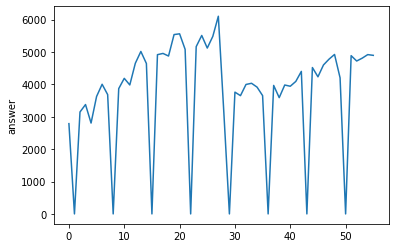

In [40]:
sns.lineplot(x=a.reset_index().index, y=a['answer'])

In [41]:
submit.to_csv('../DAT/submit5.csv', index=False)